### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### Loading Dataset

In [2]:
df = pd.read_csv("Data\\rent.csv").iloc[:,1:]
df.sample(10)

,zone,room,bathroom,floor,t_floors,area,area_unit,area_type,furnishing,facing,power_backup,available_from,contact,rent
4622,South Delhi,4,5,FIRST FLOOR,4TH FLOOR,6000.0,Sq.Ft.,Built-up Area,Semi-Furnished,NaN,NaN,Immediately,Contact Agent,Price on Request
1399,South Delhi,2,NaN,NaN,NaN,200.0,Sq.Ft.,Built-up Area,Unfurnished,NaN,NaN,Immediately,Contact Agent,"₹ 25,000"
3421,South Delhi,2,2,2,4,900.0,Sq.Ft.,Built-up Area,Furnished,East,Available,Immediately,Contact Agent,"₹ 30,000"
3980,South Delhi,4,4,SECOND FLOOR,4TH FLOOR,4500.0,Sq.Ft.,Built-up Area,Furnished,NaN,NaN,Immediately,Contact Agent,₹ 2.25 L
3615,East Delhi,2,NaN,NaN,NaN,700.0,Sq.Ft.,Built-up Area,Semi-Furnished,NaN,NaN,Immediately,Contact Agent,"₹ 17,800"
2188,East Delhi,2,NaN,NaN,NaN,504.0,Sq.Ft.,Built-up Area,Unfurnished,NaN,NaN,Immediately,Contact Agent,"₹ 15,000"
3600,East Delhi,1,NaN,NaN,NaN,436.0,Sq.Ft.,Built-up Area,Semi-Furnished,NaN,NaN,Immediately,Contact Agent,"₹ 16,700"
589,East Delhi,1,1,1,NaN,450.0,Sq.Ft.,Built-up Area,Unfurnished,East,NaN,Immediately,Contact Agent,"₹ 10,000"
4674,South Delhi,2,2,3,3,1600.0,Sq.Ft.,Built-up Area,Semi-Furnished,South East,No Back-up,Immediately,Contact Agent,"₹ 34,000"
5106,South Delhi,1,1,SECOND FLOOR,4TH FLOOR,450.0,Sq.Ft.,Built-up Area,Semi-Furnished,NaN,NaN,Immediately,Contact Agent,Price on Request


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5488 entries, 0 to 5487
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   zone            5293 non-null   object 
 1   room            5467 non-null   object 
 2   bathroom        4292 non-null   object 
 3   floor           2530 non-null   object 
 4   t_floors        2290 non-null   object 
 5   area            5488 non-null   float64
 6   area_unit       5488 non-null   object 
 7   area_type       5488 non-null   object 
 8   furnishing      5488 non-null   object 
 9   facing          2296 non-null   object 
 10  power_backup    1986 non-null   object 
 11  available_from  5255 non-null   object 
 12  contact         5488 non-null   object 
 13  rent            5488 non-null   object 
dtypes: float64(1), object(13)
memory usage: 600.4+ KB


### Data Cleaning

In [4]:
# Dropping rows with no price
df = df[~(df['rent'] == 'Price on Request')]

In [5]:
# Checking for null values
df.isnull().sum()

zone               183
room                21
bathroom           981
floor             2410
t_floors          2597
area                 0
area_unit            0
area_type            0
furnishing           0
facing            2604
power_backup      2896
available_from     203
contact              0
rent                 0
dtype: int64

In [6]:
# Dropping columns with more than 50% missing values
df = df.drop(columns = ['floor', 't_floors', 'facing'])

In [7]:
df['zone'].value_counts()

zone
South Delhi      1824
East Delhi       1391
Dwarka            605
West Delhi        467
North Delhi       177
Central Delhi      73
Name: count, dtype: int64

In [8]:
# Dropping rows with missing values in zones as they can't be imputed
df = df[~(df['zone'].isnull())]

In [9]:
df['power_backup'].value_counts()

power_backup
Available     1003
No Back-up     758
Name: count, dtype: int64

In [10]:
# Imputing missing values in 'power_backup' with 'Not Mentioned'
df['power_backup'] = df['power_backup'].fillna('Not Mentioned')

In [11]:
df['room'].value_counts(), df['bathroom'].value_counts()

(room
 2         1729
 3         1155
 1          876
 4          270
 2.5        137
 1.5        106
 1 Rk        99
 3.5         67
 Studio      63
 5           12
 6+           3
 Name: count, dtype: int64,
 bathroom
 2     1519
 1     1149
 3      706
 4      200
 5       27
 6+       1
 6        1
 Name: count, dtype: int64)

In [12]:
# Dropping rows with studio and 1 RK apartments
df = df[~((df['room'] == '1 Rk') | (df['room'] == 'Studio'))]

In [13]:
# Dropping rows with missing values in both 'room' and 'bathroom' columns
df = df[~((df['room'].isnull()) & (df['bathroom'].isnull()))]

In [14]:
df['available_from'].value_counts()

available_from
Immediately    4152
Later            36
Name: count, dtype: int64

In [15]:
# Imputing missing values in 'available_from' with 'Not Mentioned'
df['available_from'] = df['available_from'].fillna('Not Mentioned')

In [16]:
# Converting the 'room' and 'bathroom' columns into numeric columns
df['room'] = df['room'].str.split('+').str[0].astype('float64')
df['bathroom'] = df['bathroom'].str.split('+').str[0].astype('float64')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4373 entries, 0 to 5487
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   zone            4373 non-null   object 
 1   room            4355 non-null   float64
 2   bathroom        3461 non-null   float64
 3   area            4373 non-null   float64
 4   area_unit       4373 non-null   object 
 5   area_type       4373 non-null   object 
 6   furnishing      4373 non-null   object 
 7   power_backup    4373 non-null   object 
 8   available_from  4373 non-null   object 
 9   contact         4373 non-null   object 
 10  rent            4373 non-null   object 
dtypes: float64(3), object(8)
memory usage: 410.0+ KB


Imputing 'room' column by regression with 'bathroom' and 'area' as regressors

In [18]:
X1_train = df.loc[~(df['room'].isnull() | df['bathroom'].isnull()), ['bathroom', 'area']]
y1_train = df.loc[~(df['room'].isnull() | df['bathroom'].isnull()), ['room']]
X1_null = df.loc[df['room'].isnull(), ['bathroom', 'area']]

In [19]:
lr1 = LinearRegression()
lr1.fit(X1_train, y1_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [20]:
room_pred = lr1.predict(X1_null)

Imputing 'bathroom' column by regression with 'room' and 'area' as regressors

In [21]:
X2_train = df.loc[~(df['room'].isnull() | df['bathroom'].isnull()), ['room', 'area']]
y2_train = df.loc[~(df['room'].isnull() | df['bathroom'].isnull()), ['bathroom']]
X2_null = df.loc[df['bathroom'].isnull(), ['room', 'area']]

In [22]:
lr2 = LinearRegression()
lr2.fit(X2_train, y2_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [23]:
bathroom_pred = lr2.predict(X2_null)

In [24]:
# Imputing the null values with predicted values
df.loc[df['room'].isnull(), 'room'] = room_pred.round()
df.loc[df['bathroom'].isnull(), 'bathroom'] = bathroom_pred.round()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4373 entries, 0 to 5487
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   zone            4373 non-null   object 
 1   room            4373 non-null   float64
 2   bathroom        4373 non-null   float64
 3   area            4373 non-null   float64
 4   area_unit       4373 non-null   object 
 5   area_type       4373 non-null   object 
 6   furnishing      4373 non-null   object 
 7   power_backup    4373 non-null   object 
 8   available_from  4373 non-null   object 
 9   contact         4373 non-null   object 
 10  rent            4373 non-null   object 
dtypes: float64(3), object(8)
memory usage: 410.0+ KB


In [26]:
df['area_unit'].value_counts()

area_unit
Sq.Ft.    4207
Sq.Yd.     165
Acre         1
Name: count, dtype: int64

In [27]:
df[df['area_unit'] == 'Acre']

,zone,room,bathroom,area,area_unit,area_type,furnishing,power_backup,available_from,contact,rent
5104,South Delhi,3.0,3.0,2000.0,Acre,Built-up Area,Semi-Furnished,No Back-up,Immediately,Contact Agent,₹ 1.6 L


In [28]:
# Coverting areas in 'Sq.Yd.' to 'Sq.Ft.' for uniformity
df.loc[df["area_unit"] == "Sq.Yd.", "area"] *= 9

In [29]:
df['area_type'].value_counts()

area_type
Built-up Area    4176
Carpet Area       123
Saleable Area      71
Plot Area           3
Name: count, dtype: int64

In [30]:
# Dropping columns that are not neccessary anymore
df = df.drop(columns = ['area_unit'])

In [31]:
# Coverting the 'rent' column into numeric
df["rent"] = df["rent"].str.split(" ", n = 1).str[1].apply(lambda x: 
                                                           float(x.split(" ")[0])*100000 if x.endswith("L") 
                                                           else float("".join(x.split(","))))

In [32]:
df.describe()

,room,bathroom,area,rent
count,4373.000000,4373.000000,4373.000000,4373.000000
mean,2.228219,1.982621,1178.569861,47487.678253
std,0.866123,0.842419,935.577642,63807.604494
min,1.000000,1.000000,100.000000,8000.000000
25%,2.000000,1.000000,650.000000,18800.000000
50%,2.000000,2.000000,957.000000,28700.000000
75%,3.000000,2.000000,1500.000000,47000.000000
max,6.000000,6.000000,22572.000000,1000000.000000


In [33]:
# Dropping rows with unusual data
df = df[~((df["area"] < 400) & (df["room"] > 1))]
df = df[~(df['area'] < 300)]

### EDA and Feature Engineering

#### Categorical Columns

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4310 entries, 0 to 5487
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   zone            4310 non-null   object 
 1   room            4310 non-null   float64
 2   bathroom        4310 non-null   float64
 3   area            4310 non-null   float64
 4   area_type       4310 non-null   object 
 5   furnishing      4310 non-null   object 
 6   power_backup    4310 non-null   object 
 7   available_from  4310 non-null   object 
 8   contact         4310 non-null   object 
 9   rent            4310 non-null   float64
dtypes: float64(4), object(6)
memory usage: 370.4+ KB


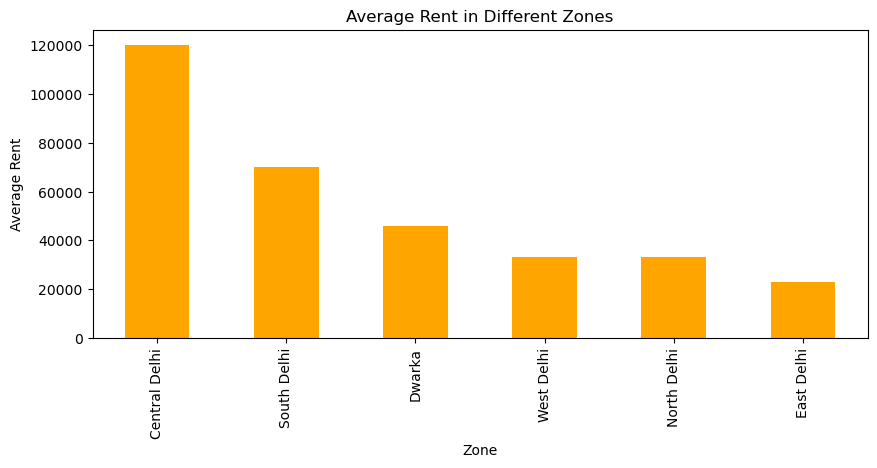

In [35]:
df.groupby('zone')['rent'].mean().sort_values(ascending = False).plot.bar(figsize = (10, 4), color = 'orange')
plt.title('Average Rent in Different Zones')
plt.xlabel('Zone')
plt.ylabel('Average Rent')
plt.show()

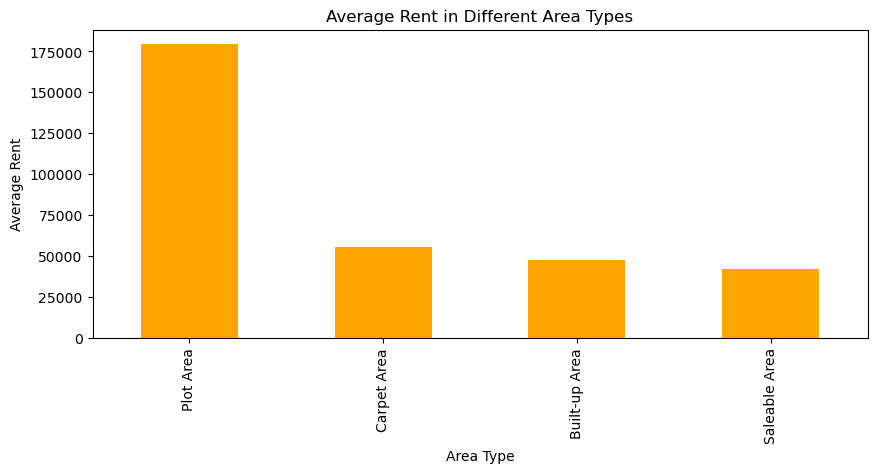

In [36]:
df.groupby('area_type')['rent'].mean().sort_values(ascending = False).plot.bar(figsize = (10, 4), color = 'orange')
plt.title('Average Rent in Different Area Types')
plt.xlabel('Area Type')
plt.ylabel('Average Rent')
plt.show()

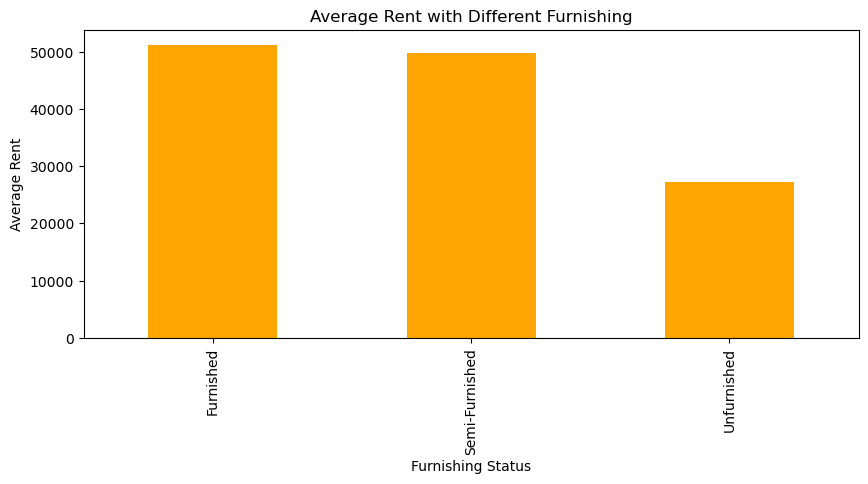

In [37]:
df.groupby('furnishing')['rent'].mean().sort_values(ascending = False).plot.bar(figsize = (10, 4), color = 'orange', )
plt.title('Average Rent with Different Furnishing')
plt.xlabel('Furnishing Status')
plt.ylabel('Average Rent')
plt.show()

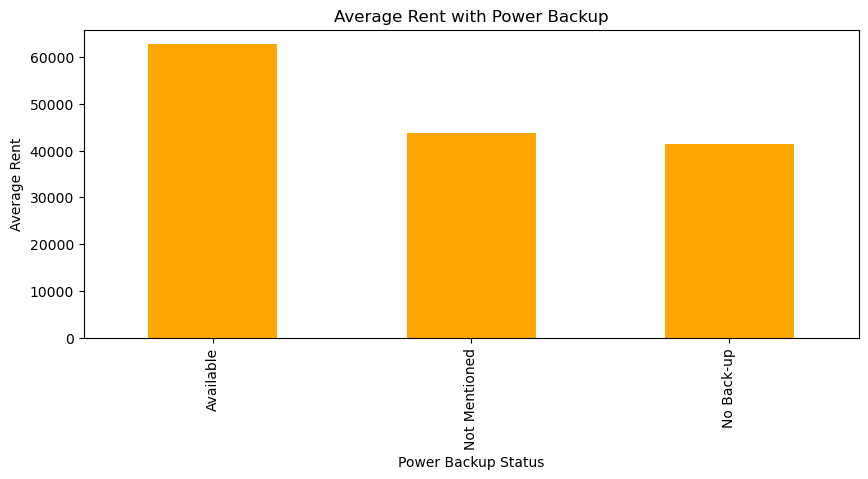

In [38]:
df.groupby('power_backup')['rent'].mean().sort_values(ascending = False).plot.bar(figsize = (10, 4), color = 'orange')
plt.title('Average Rent with Power Backup')
plt.xlabel('Power Backup Status')
plt.ylabel('Average Rent')
plt.show()

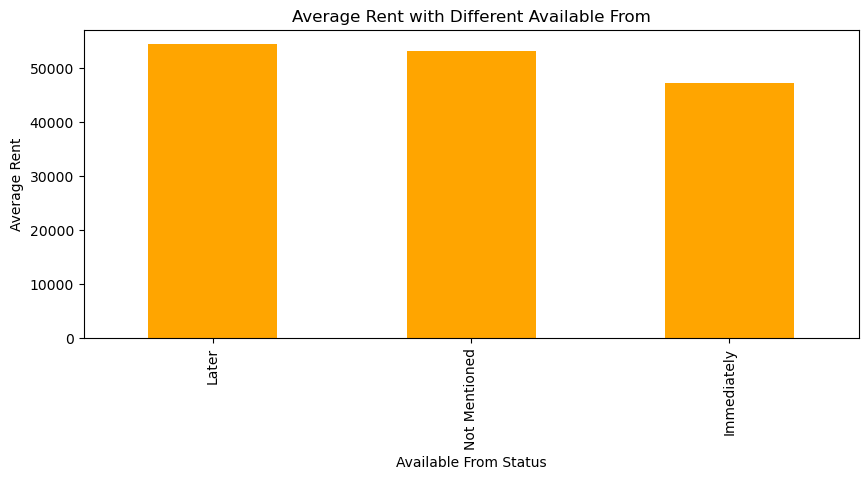

In [39]:
df.groupby('available_from')['rent'].mean().sort_values(ascending = False).plot.bar(figsize = (10, 4), color = 'orange')
plt.title('Average Rent with Different Available From')
plt.xlabel('Available From Status')
plt.ylabel('Average Rent')
plt.show()

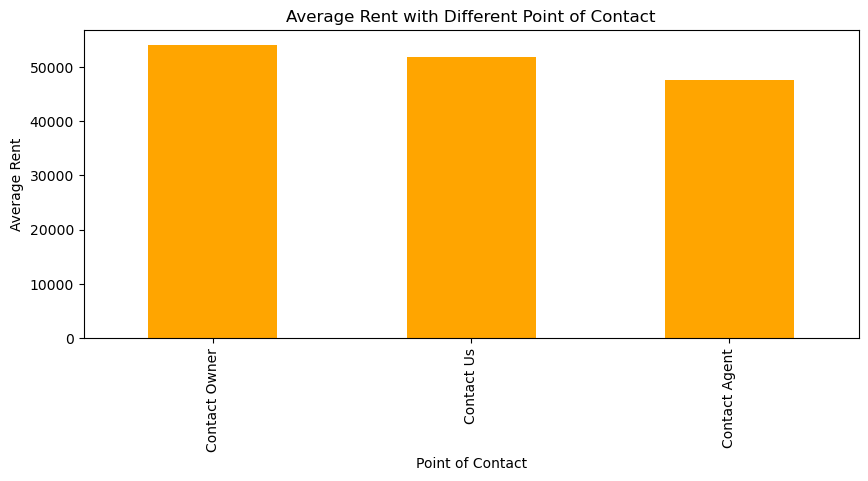

In [40]:
df.groupby('contact')['rent'].mean().sort_values(ascending = False).plot.bar(figsize = (10, 4), color = 'orange')
plt.title('Average Rent with Different Point of Contact')
plt.xlabel('Point of Contact')
plt.ylabel('Average Rent')
plt.show()

#### Numerical Columns

In [41]:
df.describe()

,room,bathroom,area,rent
count,4310.000000,4310.000000,4310.000000,4310.000000
mean,2.235963,1.988167,1193.248260,47602.463573
std,0.865660,0.843029,934.375292,64020.351327
min,1.000000,1.000000,300.000000,8000.000000
25%,2.000000,1.000000,665.750000,18800.000000
50%,2.000000,2.000000,963.500000,28650.000000
75%,3.000000,2.000000,1500.000000,47000.000000
max,6.000000,6.000000,22572.000000,1000000.000000


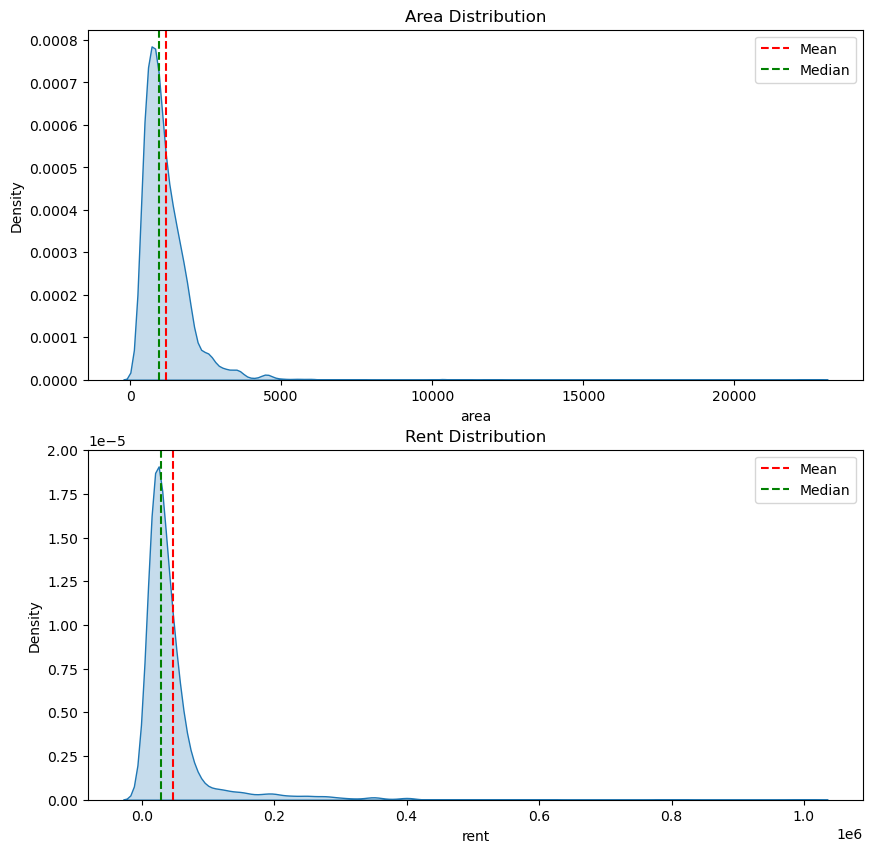

In [42]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (10,10))

sns.kdeplot(df['area'], fill = True, ax = ax[0])
ax[0].set_title('Area Distribution')
ax[0].axvline(df['area'].mean(), color = 'red', linestyle = '--', label = 'Mean')
ax[0].axvline(df['area'].median(), color = 'green', linestyle = '--', label = 'Median')

sns.kdeplot(df['rent'], fill = True, ax = ax[1])
ax[1].set_title('Rent Distribution')
ax[1].axvline(df['rent'].mean(), color = 'red', linestyle = '--', label = 'Mean')
ax[1].axvline(df['rent'].median(), color = 'green', linestyle = '--', label = 'Median')

ax[0].legend()
ax[1].legend()
plt.show()

In [43]:
print(f"Area Skewness: {df['area'].skew()}")
print(f"Rent Skewness: {df['rent'].skew()}")

Area Skewness: 7.975369309677636
Rent Skewness: 5.186189259725521


#### Multivariate Analysis

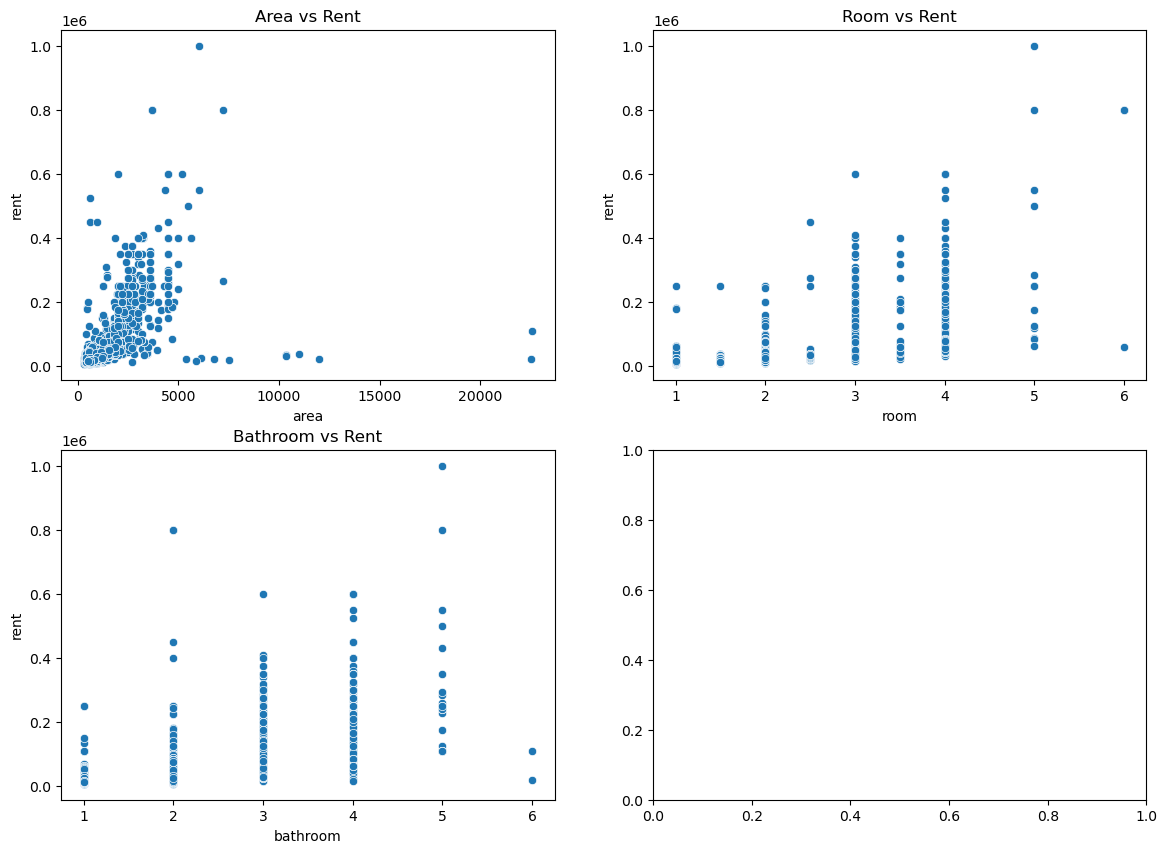

In [44]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 10))

sns.scatterplot(x = 'area', y = 'rent', data = df, ax = ax[0, 0])
ax[0, 0].set_title('Area vs Rent')

sns.scatterplot(x = 'room', y = 'rent', data = df, ax = ax[0, 1])
ax[0, 1].set_title('Room vs Rent')

sns.scatterplot(x = 'bathroom', y = 'rent', data = df, ax = ax[1, 0])
ax[1, 0].set_title('Bathroom vs Rent')

plt.show()

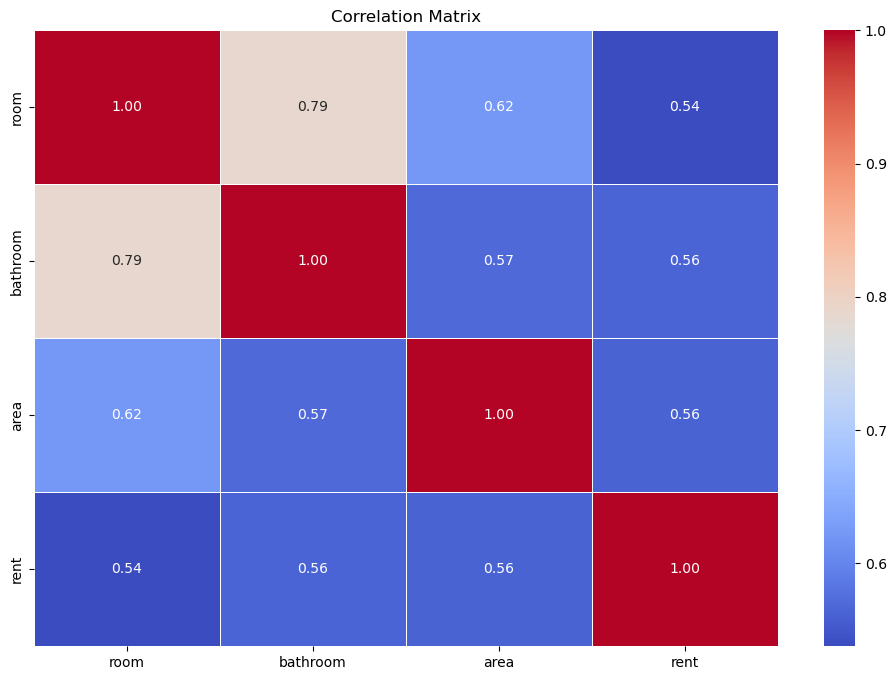

In [45]:
corr_matrix = df.corr(numeric_only = True)

plt.figure(figsize = (12, 8))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidths = 0.5)
plt.title('Correlation Matrix')
plt.show()

#### Outlier Detection and Removal

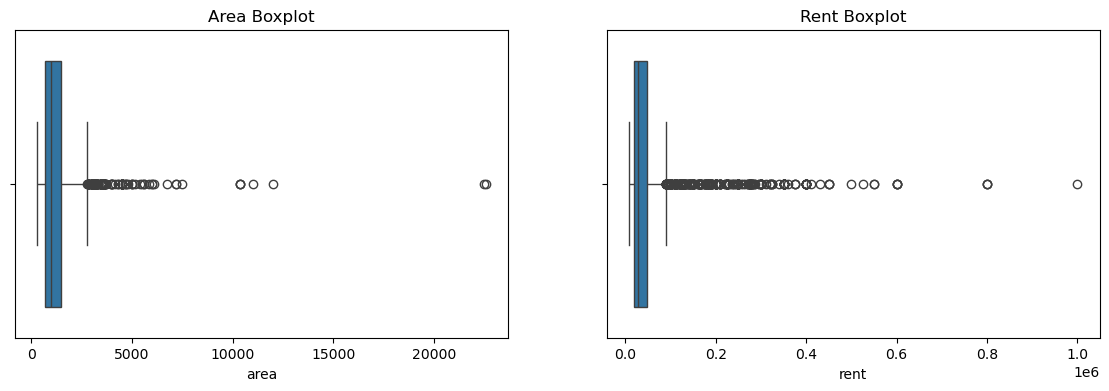

In [46]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14,4))

sns.boxplot(x = df['area'], ax = ax[0])
ax[0].set_title('Area Boxplot')

sns.boxplot(x = df['rent'], ax = ax[1])
ax[1].set_title('Rent Boxplot')

plt.show()

In [47]:
# removing outliers in 'rent' column using Z-score method
df = df[~(df['rent'] - df['rent'].mean() > 3 * df['rent'].std())]

#### Check for Multicollinearity

In [48]:
X = df[['room', 'bathroom', 'area']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

    feature       VIF
0     const  8.447522
1      room  2.822935
2  bathroom  2.504055
3      area  1.543554


In [49]:
# Creating a new feature 'total_room' by adding 'room' and 'bathroom'
df['total_room'] = df['room'] + df['bathroom']

In [50]:
X_new = df[['total_room', 'area']]

X_new = sm.add_constant(X_new)

vif_data = pd.DataFrame()
vif_data["feature"] = X_new.columns
vif_data["VIF"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
print(vif_data)

      feature       VIF
0       const  8.356369
1  total_room  1.516386
2        area  1.516386


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4195 entries, 0 to 5487
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   zone            4195 non-null   object 
 1   room            4195 non-null   float64
 2   bathroom        4195 non-null   float64
 3   area            4195 non-null   float64
 4   area_type       4195 non-null   object 
 5   furnishing      4195 non-null   object 
 6   power_backup    4195 non-null   object 
 7   available_from  4195 non-null   object 
 8   contact         4195 non-null   object 
 9   rent            4195 non-null   float64
 10  total_room      4195 non-null   float64
dtypes: float64(5), object(6)
memory usage: 393.3+ KB


### Model Fitting

In [52]:
X = df.iloc[:,[0,3,4,5,6,7,8,10]]
y = np.log(df.iloc[:,9])

In [53]:
trf = ColumnTransformer([
    ('area', Pipeline([
        ('log', FunctionTransformer(np.log)),
        ('scale', MinMaxScaler())
    ]), ['area']),

    ('total_room', MinMaxScaler(), ['total_room']),
    
    ('ohe', OneHotEncoder(sparse_output = False, drop = 'first', handle_unknown = 'ignore'), ['zone', 'area_type', 'contact', 'available_from']),
    
    ('oe', OrdinalEncoder(categories = [['Unfurnished', 'Semi-Furnished', 'Furnished'],
                                       ['No Back-up', 'Not Mentioned', 'Available'],]), ['furnishing', 'power_backup'])
], remainder='passthrough')

#### Train-Test Split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 44)

#### Linear Regression

In [55]:
lr = LinearRegression()

In [56]:
pipe = Pipeline([
    ('trf', trf),
    ('model', lr),
])

In [57]:
pipe.fit(X_train, y_train)

,steps,"[('trf', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('area', ...), ('total_room', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [58]:
y_pred = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)

mae = mean_absolute_error(y_test, y_pred)
mse = root_mean_squared_error(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1 - r2_test) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print(f"MAE: {mae}")
print(f"RMSE: {mse}\n")
print(f"R2 Score (Train): {r2_train}")
print(f"R2 Score (Test): {r2_test}\n")
print(f"Adjusted R2 Score: {adjusted_r2}")

MAE: 0.24627055765848926
RMSE: 0.324533538064962

R2 Score (Train): 0.7301177283048148
R2 Score (Test): 0.7466419073920192

Adjusted R2 Score: 0.7441999016801351


### Linear Regression Assumption Check

#### Normality of Residuals

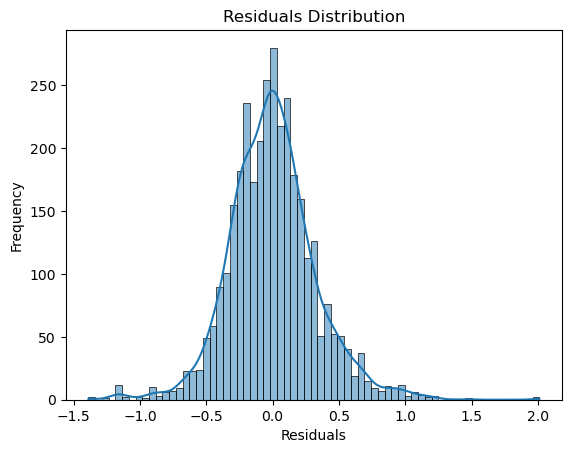

Residuals Skewness: 0.3206570518493669
Mean of Residuals: -5.774747651327989e-16


In [59]:
residuals = y_train - y_pred_train

sns.histplot(residuals, kde = True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

print(f"Residuals Skewness: {residuals.skew()}")
print(f"Mean of Residuals: {residuals.mean()}")

#### Homoscedasticity

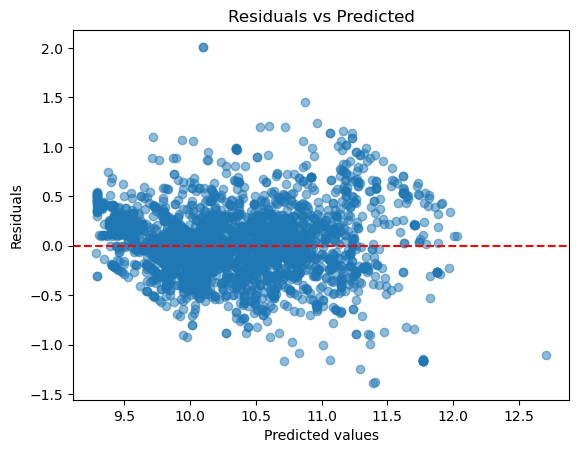

In [60]:
plt.scatter(y_pred_train, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

The variance of residuals doesn't change with the predictions implying homoscedasticity

#### Independence of Residuals

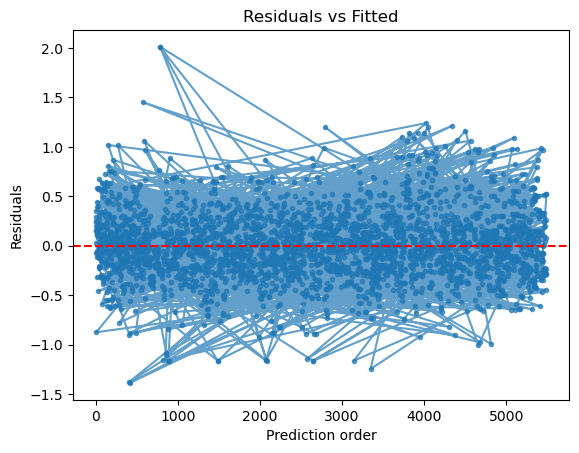

In [61]:
plt.plot(residuals, marker='.', linestyle='-', alpha=0.7,)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Prediction order")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

In [62]:
from statsmodels.stats.stattools import durbin_watson
print("Durbin-Watson statistic:", durbin_watson(residuals))

Durbin-Watson statistic: 1.990156509513047


DW Statistic = 1.99 implying no autocorrelation

### Decision Tree

In [63]:
dt = DecisionTreeRegressor(min_samples_split = 45)

In [64]:
pipe = Pipeline([
    ('trf', trf),
    ('model', dt),
])

In [65]:
pipe.fit(X_train, y_train)

,steps,"[('trf', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('area', ...), ('total_room', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [66]:
y_pred = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)

mae = mean_absolute_error(y_test, y_pred)
mse = root_mean_squared_error(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1 - r2_test) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print(f"MAE: {mae}")
print(f"RMSE: {mse}\n")
print(f"R2 Score (Train): {r2_train}")
print(f"R2 Score (Test): {r2_test}\n")
print(f"Adjusted R2 Score: {adjusted_r2}")

MAE: 0.1919868962297618
RMSE: 0.29211083159545004

R2 Score (Train): 0.8641323731263026
R2 Score (Test): 0.79473687614213

Adjusted R2 Score: 0.7927584363941023


### Random Forest

In [67]:
rf = RandomForestRegressor(min_samples_split = 45)

In [68]:
pipe = Pipeline([
    ('trf1', trf),
    ('model', rf),
])

In [69]:
pipe.fit(X_train, y_train)

,steps,"[('trf1', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('area', ...), ('total_room', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [70]:
y_pred = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)

mae = mean_absolute_error(y_test, y_pred)
mse = root_mean_squared_error(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1 - r2_test) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print(f"MAE: {mae}")
print(f"RMSE: {mse}\n")
print(f"R2 Score (Train): {r2_train}")
print(f"R2 Score (Test): {r2_test}\n")
print(f"Adjusted R2 Score: {adjusted_r2}")

MAE: 0.18782482590893912
RMSE: 0.2680833296530869

R2 Score (Train): 0.8527226161471027
R2 Score (Test): 0.8271158298499767

Adjusted R2 Score: 0.8254494764027476
